### Exploring and preprocessing

In [11]:
import kagglehub
path = kagglehub.dataset_download('sondosaabed/casia-iris-thousand')

print('Data source import complete.')

Data source import complete.


In [9]:
import os
import PIL
import math
import cv2
import random
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
def load_dataset(path):
    """
    Loading the dataset into a pandas datframe.
    The images of CASIA-Iris-Thousand are stored as:    /CASIA-Iris-Thousand/YYY/E/S5YYYENN.jpg

        YYY: the unique identifier of the subject in the subset
        E: ‘L’ denotes left eye and ‘R’ denotes right eye
        NN: the index of the image in the class

    Args:
        path(str): string that has the path of the dataset
    Returns:
        df(pd.DataFrame): the loaded dataframe
    """
    labels = []
    images = []

    for folder in os.listdir(path):
        for lr in os.listdir(path+'/'+folder): #left or right
            for image in os.listdir(path+'/'+folder+'/'+lr):
                if image.endswith('b') is False:
                    images.append(path+'/'+folder+'/'+lr+'/'+image)
                    labels.append(folder+'-'+lr) #+'-'+lr

    df = pd.DataFrame(list(zip(labels, images)), columns=['Label', 'ImagePath'])
    return df, labels, images

In [13]:
df, labels, images = load_dataset('/kaggle/input/casia-iris-thousand/CASIA-Iris-Thousand/CASIA-Iris-Thousand')

In [14]:
def show_random_samples(df, num):
    """
    Shows a sample on the dataframe in a specific location.
    Args:
        df (pd.DataFrame): the dataset
        num (int): the number of random samples to display
    Return:
        Nothing but shows a sample in the display
    """
    random.seed(1190652)
    random_indices = random.sample(range(df.shape[0]), num)
    num_rows = math.ceil(num / 4)

    fig, axes = plt.subplots(num_rows, 4, figsize=(20, num_rows * 5))
    for i, idx in enumerate(random_indices):
        row = i // 4
        col = i % 4

        if idx < df.shape[0]:
            image_path =  df.loc[idx, "ImagePath"]
            image = PIL.Image.open(image_path)
            ax = axes[row, col] if num_rows > 1 else axes[col]
            ax.imshow(image, cmap='gray')
            ax.set_title(f"Image {idx} Person Label: {df.loc[idx, 'Label']}")
            ax.axis("off")

    plt.suptitle("Figure 3: Random Small Sample of the Dataset")
    plt.tight_layout()
    plt.show()

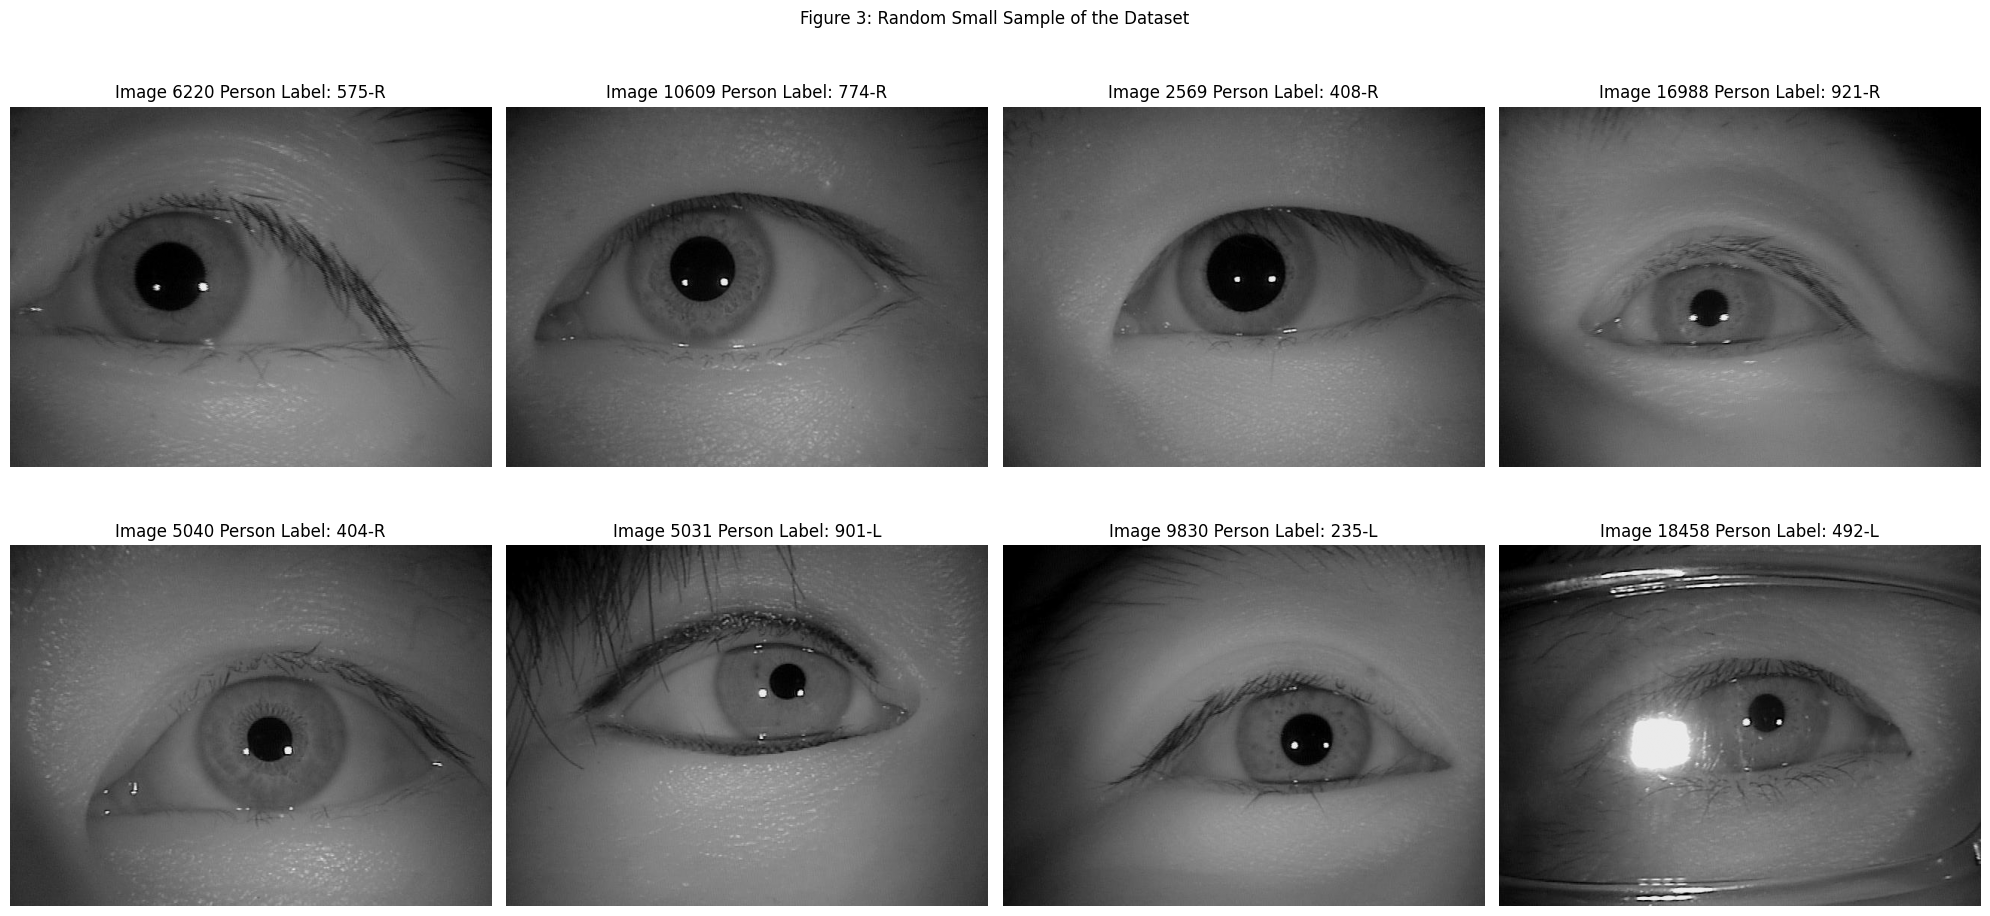

In [15]:
show_random_samples(df, 8)

In [17]:
# Dataset Config
SIZE = 20000
NUM_CLASSES = 2000
IMG_HEIGHT = 224
IMG_WIDTH = 224
NUM_CHANNELS = 1
input_shape=(IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)

In [18]:
def resize_keep_aspect_ration(img, target_height=IMG_HEIGHT, target_width=IMG_WIDTH, pad_value=255):
    """
    Resize an image to a specific size keeping the aspect ratio using padding
    Args:
        - img (np.array): image
        - target_height (int): with the deafult value as IMG_HEIGHT
        - target_width (int): with the deafult value as IMG_WIDTH
        - pad_value (int): the padding value foe the left of the image with the deafult value is 255
    Returns:
        - The resized image
    """
    aspect_ratio = img.shape[1] / img.shape[0]

    ## Get the new sizes with keeping the aspect ratio
    if aspect_ratio > target_width / target_height:
        new_width = target_width
        new_height = int(target_width / aspect_ratio)
    else:
        new_height = target_height
        new_width = int(target_height * aspect_ratio)

    resized_img = cv2.resize(img, (new_width, new_height))

    ## Padding up and down so the image is in the middle
    preprocessed_img = np.full((target_height, target_width), pad_value, dtype=np.uint8)
    x_offset = (target_width - new_width) // 2
    y_offset = (target_height - new_height) // 2
    preprocessed_img[y_offset:y_offset + new_height, x_offset:x_offset + new_width] = resized_img

    return preprocessed_img

In [19]:
def preprocess_image(img_dir):
    """
    Resizing imgaes with keeping the aspect ratio.
    Args:
        img_dir(str): Image path on the dataset
        target_height(int): the targeted height to be resized
        target_width(int): the targeted width to be resized
        pad_value(int): used as the padding value for the resized image
    Returns:
        preprocessed_img (cv.Imgae): processsed image
    """
    img = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    img = resize_keep_aspect_ration(img)
    img = img/255.

    return img

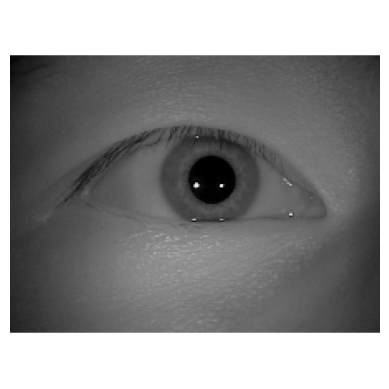

Processed image size (W, H): 50176


In [20]:
image = preprocess_image(df.iloc[15]['ImagePath'])
plt.imshow(image)
plt.imshow(preprocess_image(df.iloc[15]['ImagePath']), cmap="gray")
plt.axis("off")
plt.show()

print("Processed image size (W, H):", image.size)
# 50176 = 224 x 224

In [21]:
def preprocess_labels(df):
    """
    Prepares labels for training indluding transform to string and then encode.
    Args:
        df(pd.DataFrame): dataset non-encoded labels and images paths
    Rteurns:
        labels(np.array): prepared labels for training
    """
    labels = df['Label'].astype(str)
    le = LabelEncoder()
    le.fit(labels)
    labels = le.transform(labels)
    return labels

In [22]:
print("Label after encoding: ", preprocess_labels(df)[120])
print("Label before encoding: ",df.iloc[120]['Label'])

Label after encoding:  959
Label before encoding:  479-R


### 1) MobileNet model ✅

*  Test Accuracy on 150-Class Subset: 90.33%



In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import os

# ========== STEP 0: MOUNT GOOGLE DRIVE ==========
from google.colab import drive
drive.mount('/content/drive')

# Define the path to save model inside Colab Notebooks in Drive
MODEL_PATH = '/content/drive/My Drive/Colab Notebooks/mobilenet_casia_150classes.keras'

IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS = 224, 224, 1
NUM_SELECTED_CLASSES = 150

# ========== STEP 1: FILTER TO 500 UNIQUE CLASSES ==========

unique_labels = df['Label'].unique()[:NUM_SELECTED_CLASSES]
filtered_df = df[df['Label'].isin(unique_labels)].reset_index(drop=True)

# ========== STEP 2: PREPROCESS IMAGES ==========

preprocessed_images = []
for i in range(len(filtered_df)):
    image = preprocess_image(filtered_df.iloc[i]['ImagePath'])  # Already defined
    preprocessed_images.append(image)

x_data = np.array(preprocessed_images).reshape(-1, IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)
x_data = np.repeat(x_data, 3, axis=-1)  # Convert to RGB for MobileNet

# ========== STEP 3: PROCESS LABELS ==========

labels = filtered_df['Label'].astype(str)
le = LabelEncoder()
labels = le.fit_transform(labels)
y_data = to_categorical(labels)
NUM_CLASSES = y_data.shape[1]

# ========== STEP 4: SPLIT ==========

x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42, stratify=labels
)

# ========== STEP 5: LOAD MobileNet BASE ==========

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

# ========== STEP 6: BUILD MODEL ==========

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

# ========== STEP 7: COMPILE & TRAIN ==========

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint = ModelCheckpoint(MODEL_PATH, monitor='val_accuracy', save_best_only=True, verbose=1)

history = model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[early_stop, checkpoint]
)

# ========== STEP 8: EVALUATE ==========

loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy on 150-Class Subset: {accuracy * 100:.2f}%")

# ========== STEP 9: SAVE MODEL ==========

model.save(MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0211 - loss: 5.9113
Epoch 1: val_accuracy improved from -inf to 0.01250, saving model to /content/drive/My Drive/Colab Notebooks/mobilenet_casia_150classes.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.0210 - loss: 5.8916 - val_accuracy: 0.0125 - val_loss: 4.9028
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0466 - loss: 4.6869
Epoch 2: val_accuracy improved from 0.01250 to 0.09167, saving model to /content/drive/My Drive/Colab Notebooks/mobilenet_casia_150classes.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.0471 - loss: 4.6835 - val_accuracy: 0.0917 - val_loss: 4.6508
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0912 - loss: 4.1699
Epoch 3: val_accuracy improved from 0.09167 to 0.17500, saving model to /content/drive/My Drive/Colab Not

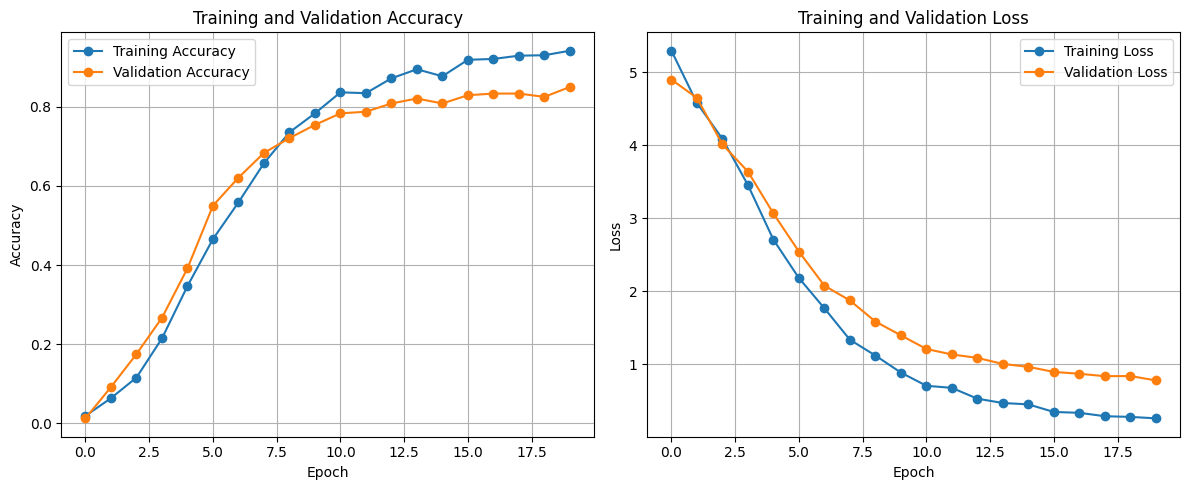

In [ ]:
import matplotlib.pyplot as plt

# Plotting accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### 2) MobileNet with EarlyStopping ✅


*   Test Accuracy on 150-Class Subset: 91.67%



In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import os

# ========== STEP 0: MOUNT GOOGLE DRIVE ==========
from google.colab import drive
drive.mount('/content/drive')

# Define the path to save model inside Colab Notebooks in Drive
MODEL_PATH = '/content/drive/My Drive/Colab Notebooks/mobilenet_casia_150classes.keras'

IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS = 224, 224, 1
NUM_SELECTED_CLASSES = 150

# ========== STEP 1: FILTER TO 150 UNIQUE CLASSES ==========
unique_labels = df['Label'].unique()[:NUM_SELECTED_CLASSES]
filtered_df = df[df['Label'].isin(unique_labels)].reset_index(drop=True)

# ========== STEP 2: PREPROCESS IMAGES ==========
preprocessed_images = []
for i in range(len(filtered_df)):
    image = preprocess_image(filtered_df.iloc[i]['ImagePath'])  # Already defined
    preprocessed_images.append(image)

x_data = np.array(preprocessed_images).reshape(-1, IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)
x_data = np.repeat(x_data, 3, axis=-1)  # Convert to RGB for MobileNet

# ========== STEP 3: PROCESS LABELS ==========
labels = filtered_df['Label'].astype(str)
le = LabelEncoder()
labels = le.fit_transform(labels)
y_data = to_categorical(labels)
NUM_CLASSES = y_data.shape[1]

# ========== STEP 4: SPLIT ==========
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42, stratify=labels
)

# ========== STEP 5: LOAD MobileNet BASE ==========
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

# ========== STEP 6: BUILD MODEL ==========
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

# ========== STEP 7: COMPILE ==========
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ========== STEP 8: CALLBACKS ==========
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    MODEL_PATH,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# ========== STEP 9: TRAIN ==========
history = model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, checkpoint]
)

# ========== STEP 10: EVALUATE ==========
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy on 150-Class Subset: {accuracy * 100:.2f}%")

# ========== STEP 11: SAVE MODEL ==========
model.save(MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0181 - loss: 6.3433
Epoch 1: val_loss improved from inf to 4.84940, saving model to /content/drive/My Drive/Colab Notebooks/mobilenet_casia_150classes.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.0183 - loss: 6.3151 - val_accuracy: 0.0292 - val_loss: 4.8494
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0333 - loss: 4.5926
Epoch 2: val_loss improved from 4.84940 to 4.49975, saving model to /content/drive/My Drive/Colab Notebooks/mobilenet_casia_150classes.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - accuracy: 0.0335 - loss: 4.5907 - val_accuracy: 0.1000 - val_loss: 4.4998
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1078 - loss: 4.1281
Epoch 3: val_loss improved from 4.49975 to 4.14502, saving model to /content/drive/My Drive/Colab Notebooks/mobil

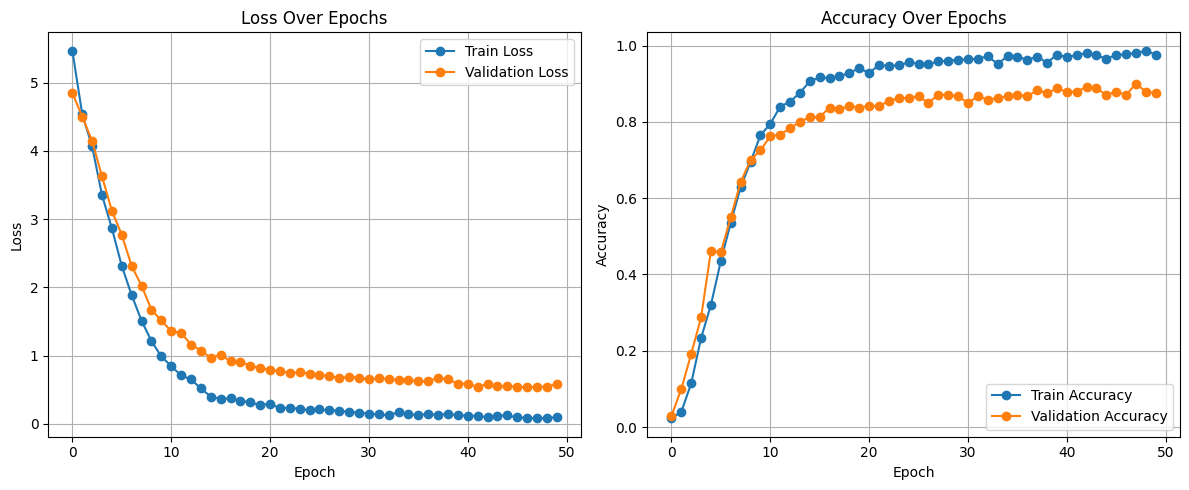

In [ ]:
# ========== STEP 12: PLOT LEARNING CURVES ==========
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### 3) MobileNet with Dropout ✅


*   Test Accuracy on 150-Class Subset: 91.33%



In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import os

# ========== STEP 0: MOUNT GOOGLE DRIVE ==========
from google.colab import drive
drive.mount('/content/drive')

# Define the path to save model inside Colab Notebooks in Drive
MODEL_PATH = '/content/drive/My Drive/Colab Notebooks/mobilenet_casia_150classesdo.keras'

IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS = 224, 224, 1
NUM_SELECTED_CLASSES = 150

# ========== STEP 1: FILTER TO 150 UNIQUE CLASSES ==========
unique_labels = df['Label'].unique()[:NUM_SELECTED_CLASSES]
filtered_df = df[df['Label'].isin(unique_labels)].reset_index(drop=True)

# ========== STEP 2: PREPROCESS IMAGES ==========
preprocessed_images = []
for i in range(len(filtered_df)):
    image = preprocess_image(filtered_df.iloc[i]['ImagePath'])  # Already defined
    preprocessed_images.append(image)

x_data = np.array(preprocessed_images).reshape(-1, IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)
x_data = np.repeat(x_data, 3, axis=-1)  # Convert to RGB for MobileNet

# ========== STEP 3: PROCESS LABELS ==========
labels = filtered_df['Label'].astype(str)
le = LabelEncoder()
labels = le.fit_transform(labels)
y_data = to_categorical(labels)
NUM_CLASSES = y_data.shape[1]

# ========== STEP 4: SPLIT ==========
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42, stratify=labels
)

# ========== STEP 5: LOAD MobileNet BASE ==========
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

# ========== STEP 6: BUILD MODEL ==========
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),  # Only Dropout for regularization
    Dense(NUM_CLASSES, activation='softmax')
])

# ========== STEP 7: COMPILE ==========
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ========== STEP 8: CALLBACK ==========
checkpoint = ModelCheckpoint(
    MODEL_PATH,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# ========== STEP 9: TRAIN ==========
history = model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[checkpoint]
)

# ========== STEP 10: EVALUATE ==========
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy on 150-Class Subset: {accuracy * 100:.2f}%")

# ========== STEP 11: SAVE MODEL ==========
model.save(MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0110 - loss: 5.9619
Epoch 1: val_loss improved from inf to 4.83995, saving model to /content/drive/My Drive/Colab Notebooks/mobilenet_casia_150classesdo.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.0112 - loss: 5.9408 - val_accuracy: 0.0458 - val_loss: 4.8400
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0609 - loss: 4.5963
Epoch 2: val_loss improved from 4.83995 to 4.37230, saving model to /content/drive/My Drive/Colab Notebooks/mobilenet_casia_150classesdo.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.0612 - loss: 4.5935 - val_accuracy: 0.1417 - val_loss: 4.3723
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0902 - loss: 4.1031
Epoch 3: val_loss improved from 4.37230 to 4.05951, saving model to /content/drive/My Drive/Colab Notebooks/mo

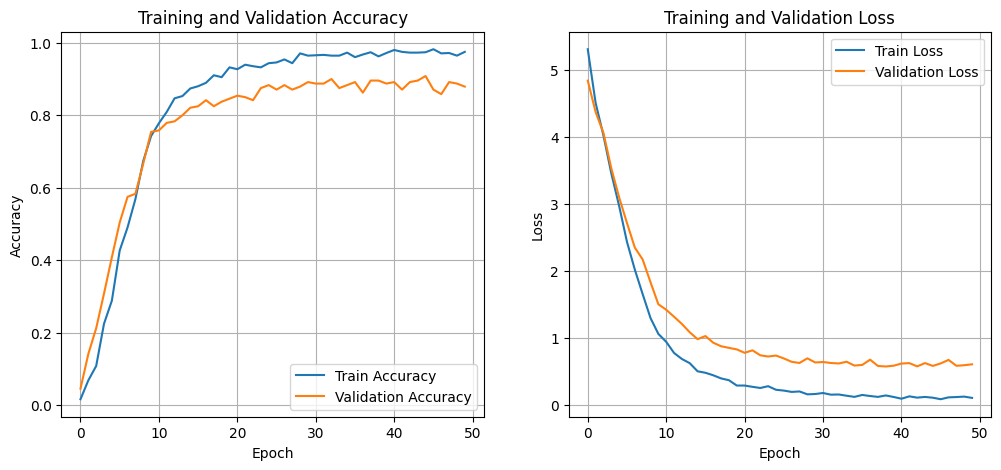

In [ ]:
# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()




### 4) VGG with early stopping and drop out ✅


*   Test Accuracy on 150-Class Subset: 45.33%



In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import os

# ========== STEP 0: MOUNT GOOGLE DRIVE ==========
from google.colab import drive
drive.mount('/content/drive')

# Define the path to save model inside Colab Notebooks in Drive
MODEL_PATH = '/content/drive/My Drive/Colab Notebooks/vgg16_casia_150classes.keras'

IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS = 224, 224, 1
NUM_SELECTED_CLASSES = 150

# ========== STEP 1: FILTER TO 150 UNIQUE CLASSES ==========
unique_labels = df['Label'].unique()[:NUM_SELECTED_CLASSES]
filtered_df = df[df['Label'].isin(unique_labels)].reset_index(drop=True)

# ========== STEP 2: PREPROCESS IMAGES ==========
preprocessed_images = []
for i in range(len(filtered_df)):
    image = preprocess_image(filtered_df.iloc[i]['ImagePath'])  # You must define this
    preprocessed_images.append(image)

x_data = np.array(preprocessed_images).reshape(-1, IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)
x_data = np.repeat(x_data, 3, axis=-1)  # Convert grayscale to RGB

# ========== STEP 3: PROCESS LABELS ==========
labels = filtered_df['Label'].astype(str)
le = LabelEncoder()
labels = le.fit_transform(labels)
y_data = to_categorical(labels)
NUM_CLASSES = y_data.shape[1]

# ========== STEP 4: SPLIT ==========
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42, stratify=labels
)

# ========== STEP 5: LOAD VGG16 BASE ==========
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

# ========== STEP 6: BUILD MODEL ==========
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

# ========== STEP 7: COMPILE & TRAIN ==========
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(MODEL_PATH, monitor='val_accuracy', save_best_only=True, verbose=1)

history = model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[early_stop, checkpoint]
)

# ========== STEP 8: EVALUATE ==========
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy on 150-Class Subset: {accuracy * 100:.2f}%")

# ========== STEP 9: SAVE MODEL ==========
model.save(MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.0136 - loss: 5.2822 
Epoch 1: val_accuracy improved from -inf to 0.00833, saving model to /content/drive/My Drive/Colab Notebooks/vgg16_casia_150classes.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 462s 15s/step - accuracy: 0.0134 - loss: 5.2780 - val_accuracy: 0.0083 - val_loss: 4.9742
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.0190 - loss: 4.9363 
Epoch 2: val_accuracy improved from 0.00833 to 0.02500, saving model to /content/drive/My Drive/Colab Notebooks/vgg16_casia_150classes.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 543s 17s/step - accuracy: 0.0190 - loss: 4.9356 - val_accuracy: 0.0250 - val_loss: 4.8930
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.0216 - loss: 4.8691 
Epoch 3: val_accuracy improved from 0.02500 to 0.045

### 5) VGG without early stopping and drop out ✅

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import os

# ========== STEP 0: MOUNT GOOGLE DRIVE ==========
from google.colab import drive
drive.mount('/content/drive')

# Define the path to save model inside Colab Notebooks in Drive
MODEL_PATH = '/content/drive/My Drive/Colab Notebooks/vgg16_casia_150classesno.keras'

IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS = 224, 224, 1
NUM_SELECTED_CLASSES = 150

# ========== STEP 1: FILTER TO 150 UNIQUE CLASSES ==========
unique_labels = df['Label'].unique()[:NUM_SELECTED_CLASSES]
filtered_df = df[df['Label'].isin(unique_labels)].reset_index(drop=True)

# ========== STEP 2: PREPROCESS IMAGES ==========
preprocessed_images = []
for i in range(len(filtered_df)):
    image = preprocess_image(filtered_df.iloc[i]['ImagePath'])  # You must define this function
    preprocessed_images.append(image)

x_data = np.array(preprocessed_images).reshape(-1, IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)
x_data = np.repeat(x_data, 3, axis=-1)  # Convert grayscale to RGB

# ========== STEP 3: PROCESS LABELS ==========
labels = filtered_df['Label'].astype(str)
le = LabelEncoder()
labels = le.fit_transform(labels)
y_data = to_categorical(labels)
NUM_CLASSES = y_data.shape[1]

# ========== STEP 4: SPLIT ==========
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42, stratify=labels
)

# ========== STEP 5: LOAD VGG16 BASE ==========
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

# ========== STEP 6: BUILD MODEL ==========
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

# ========== STEP 7: COMPILE & TRAIN ==========
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint = ModelCheckpoint(MODEL_PATH, monitor='val_accuracy', save_best_only=True, verbose=1)

history = model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[checkpoint]
)

# ========== STEP 8: EVALUATE ==========
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy on 150-Class Subset: {accuracy * 100:.2f}%")

# ========== STEP 9: SAVE MODEL ==========
model.save(MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.0111 - loss: 5.1572 
Epoch 1: val_accuracy improved from -inf to 0.02500, saving model to /content/drive/My Drive/Colab Notebooks/vgg16_casia_150classesno.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 853s 28s/step - accuracy: 0.0112 - loss: 5.1547 - val_accuracy: 0.0250 - val_loss: 4.9616
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.0505 - loss: 4.7772 
Epoch 2: val_accuracy improved from 0.02500 to 0.04583, saving model to /content/drive/My Drive/Colab Notebooks/vgg16_casia_150classesno.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 811s 27s/step - accuracy: 0.0511 - loss: 4.7762 - val_accuracy: 0.0458 - val_loss: 4.8746
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.1278 - loss: 4.5273 
Epoch 3: val_accuracy improved from 0.04583 to 0

### 6) GoogLeNet (InceptionV3) with early stopping and dropout ✅


*   Test Accuracy on 150-Class Subset: 73.00%



In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import os

# ========== STEP 0: MOUNT GOOGLE DRIVE ==========
from google.colab import drive
drive.mount('/content/drive')

# Define the path to save model inside Colab Notebooks in Drive
MODEL_PATH = '/content/drive/My Drive/Colab Notebooks/googlenet_casia_150classes.keras'

IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS = 224, 224, 1
NUM_SELECTED_CLASSES = 150

# ========== STEP 1: FILTER TO 150 UNIQUE CLASSES ==========
unique_labels = df['Label'].unique()[:NUM_SELECTED_CLASSES]
filtered_df = df[df['Label'].isin(unique_labels)].reset_index(drop=True)

# ========== STEP 2: PREPROCESS IMAGES ==========
preprocessed_images = []
for i in range(len(filtered_df)):
    image = preprocess_image(filtered_df.iloc[i]['ImagePath'])  # You must define this
    preprocessed_images.append(image)

x_data = np.array(preprocessed_images).reshape(-1, IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)
x_data = np.repeat(x_data, 3, axis=-1)  # Convert grayscale to RGB

# ========== STEP 3: PROCESS LABELS ==========
labels = filtered_df['Label'].astype(str)
le = LabelEncoder()
labels = le.fit_transform(labels)
y_data = to_categorical(labels)
NUM_CLASSES = y_data.shape[1]

# ========== STEP 4: SPLIT ==========
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42, stratify=labels
)

# ========== STEP 5: LOAD InceptionV3 BASE ==========
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

# ========== STEP 6: BUILD MODEL ==========
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

# ========== STEP 7: COMPILE & TRAIN ==========
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(MODEL_PATH, monitor='val_accuracy', save_best_only=True, verbose=1)

history = model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[early_stop, checkpoint]
)

# ========== STEP 8: EVALUATE ==========
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy on 150-Class Subset: {accuracy * 100:.2f}%")

# ========== STEP 9: SAVE MODEL ==========
model.save(MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0126 - loss: 5.5946
Epoch 1: val_accuracy improved from -inf to 0.01250, saving model to /content/drive/My Drive/Colab Notebooks/googlenet_casia_150classes.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 188s 6s/step - accuracy: 0.0127 - loss: 5.5829 - val_accuracy: 0.0125 - val_loss: 4.9254
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.0121 - loss: 4.8802
Epoch 2: val_accuracy did not improve from 0.01250
30/30 ━━━━━━━━━━━━━━━━━━━━ 210s 6s/step - accuracy: 0.0122 - loss: 4.8800 - val_accuracy: 0.0125 - val_loss: 4.8332
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.0333 - loss: 4.7350
Epoch 3: val_accuracy improved from 0.01250 to 0.05833, saving model to /content/drive/My Drive/Colab Notebooks/googlenet_casia_150classes.keras
3

### 7) GoogLeNet (InceptionV3) without early stopping and dropout ✅


*   Test Accuracy on 150-Class Subset: 84.00%



In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import os

# ========== STEP 0: MOUNT GOOGLE DRIVE ==========
from google.colab import drive
drive.mount('/content/drive')

# Define the path to save model inside Colab Notebooks in Drive
MODEL_PATH = '/content/drive/My Drive/Colab Notebooks/googlenet_casia_150classes.keras'

IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS = 224, 224, 1
NUM_SELECTED_CLASSES = 150

# ========== STEP 1: FILTER TO 150 UNIQUE CLASSES ==========
unique_labels = df['Label'].unique()[:NUM_SELECTED_CLASSES]
filtered_df = df[df['Label'].isin(unique_labels)].reset_index(drop=True)

# ========== STEP 2: PREPROCESS IMAGES ==========
preprocessed_images = []
for i in range(len(filtered_df)):
    image = preprocess_image(filtered_df.iloc[i]['ImagePath'])  # You must define this
    preprocessed_images.append(image)

x_data = np.array(preprocessed_images).reshape(-1, IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)
x_data = np.repeat(x_data, 3, axis=-1)  # Convert grayscale to RGB

# ========== STEP 3: PROCESS LABELS ==========
labels = filtered_df['Label'].astype(str)
le = LabelEncoder()
labels = le.fit_transform(labels)
y_data = to_categorical(labels)
NUM_CLASSES = y_data.shape[1]

# ========== STEP 4: SPLIT ==========
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42, stratify=labels
)

# ========== STEP 5: LOAD InceptionV3 BASE ==========
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

# ========== STEP 6: BUILD MODEL ==========
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

# ========== STEP 7: COMPILE & TRAIN ==========
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint = ModelCheckpoint(MODEL_PATH, monitor='val_accuracy', save_best_only=True, verbose=1)

history = model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[checkpoint]
)

# ========== STEP 8: EVALUATE ==========
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy on 150-Class Subset: {accuracy * 100:.2f}%")

# ========== STEP 9: SAVE MODEL ==========
model.save(MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0385 - loss: 5.3388
Epoch 1: val_accuracy improved from -inf to 0.03750, saving model to /content/drive/My Drive/Colab Notebooks/googlenet_casia_150classes.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 205s 7s/step - accuracy: 0.0390 - loss: 5.3272 - val_accuracy: 0.0375 - val_loss: 4.7567
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1757 - loss: 3.8355
Epoch 2: val_accuracy improved from 0.03750 to 0.17500, saving model to /content/drive/My Drive/Colab Notebooks/googlenet_casia_150classes.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 212s 7s/step - accuracy: 0.1776 - loss: 3.8303 - val_accuracy: 0.1750 - val_loss: 4.2508
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5078 - loss: 2.6393
Epoch 3: val_accuracy improved from 0.17500 to 0.28333, saving model to /content/drive/My Drive/Colab N